# False Positives in 4 hours calculations

Converting the sigma significance level into the number of (false) positives in 4 hours worth of data

In [4]:
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
from IPython.display import clear_output
from scipy.optimize import root_scalar

class Curve:
    def __init__(self, k_T, lambda_1, t=0):
        self.a = k_T
        self.b = -lambda_1
        self.t = t
        ## a log(mu) + b(mu-1)
        ## t contains time offset, because lambda_1 is incorporated into b.
    
    def __repr__(self):
        return f'Curve: {self.a} log(mu) + {self.b} (mu-1), t={self.t}.'
    
    def evaluate(self, mu):
        return np.maximum(self.a*np.log(mu) + self.b*(mu-1), 0)
    
    def update(self, k_T, lambda_1):
        return Curve(self.a + k_T, -self.b + lambda_1, self.t-1)
    
    def ymax(self):
        return self.evaluate(self.xmax())
    
    def xmax(self):
        return -self.a/self.b
    
    def is_negative(self):
        #returns true if slope at mu=1 is negative (i.e. no evidence for positive change)
        return (self.a + self.b) < 0
    
    def dominates(self, other_curve):
        self_root = -self.a/self.b #other non mu=1 root: the curve's "length"
        other_root = -other_curve.a/other_curve.b
        self_slope = self.a + self.b  #slope at mu=1: the curve's "height"
        other_slope = other_curve.a + other_curve.b
        return (self_root > other_root)and(self_slope > other_slope)
    
def focus_step(curve_list, k_T, lambda_1):
    new_curve_list = []
    global_max = 0
    time_offset = 0
    
    if not curve_list: #list is empty
        
        if k_T <= lambda_1:
            return new_curve_list, global_max, time_offset
        else:
            updated_c = Curve(k_T, lambda_1, t=-1)
            new_curve_list.append(updated_c)
            global_max = updated_c.ymax()
            time_offset = updated_c.t
            
    else: #list not empty: go through and prune
        
        updated_c = curve_list[0].update(k_T, lambda_1) #check leftmost quadratic separately
        if updated_c.is_negative(): #our leftmost quadratic is negative i.e. we have no quadratics
            return new_curve_list, global_max, time_offset
        else:
            new_curve_list.append(updated_c)
            if updated_c.ymax() > global_max:   #we have a new candidate for global maximum
                global_max = updated_c.ymax()
                time_offset = updated_c.t

            for c in curve_list[1:]+[Curve(0, 0)]:#add on new quadratic to end of list
                updated_c = c.update(k_T, lambda_1)

                if new_curve_list[-1].dominates(updated_c):
                    break #quadratic q and all quadratics to the right of it are pruned out by q's left neighbour
                elif updated_c.is_negative():
                    pass #delete q and move on
                else:
                    new_curve_list.append(updated_c)

                    if updated_c.ymax() > global_max:   #we have a new candidate for global maximum
                        global_max = updated_c.ymax()
                        time_offset = updated_c.t
            
            
        
    return new_curve_list, global_max, time_offset

def plot_curves(curve_list, threshold=25, T=0):
    fig = plt.figure()
    ax = fig.add_subplot(1, 1, 1)
    ax.set_title("FOCuS step at detection time $T=67$")
    
    ax.set_xlabel("$\mu$")
    ax.set_ylabel("$S_{T}(\mu)$", rotation=0)
    
    ax.set_ylim(-1, threshold+1)
    ax.set_xlim(-0.2, 5.2)
    
    
    ax.axhline(threshold, color='C1')

    mu = np.linspace(0.2, 10, 100) #the x-axis for the plot
    
    for c in curve_list:
        ax.plot(mu, c.evaluate(mu), label=f'$\\tau={c.t+T+1}$')
    
    ax.axhline(0, color='C0')

    if curve_list:
        ax.legend(loc='upper left')
    return fig

def focus(X, lambda_1, threshold, plot=False):
    if np.ndim(lambda_1)==0:#scalar
        lambda_1 = np.full(X.shape, lambda_1)
        
    global_max_list = []
    
    curve_list = []
    for T in range(len(X)):
        curve_list, global_max, time_offset = focus_step(curve_list, X[T], lambda_1[T])
        global_max_list.append(global_max)
        
        if plot:
            clear_output(wait=True)
            plot_curves(curve_list, threshold, T)
            plt.show()
        
        if global_max > threshold:
            return global_max, time_offset+T+1, T, global_max_list
        
    return 0, len(X)+1, len(X), global_max_list #no change found by end of signal

In [57]:
λ = 20
np.random.seed(42)
threshold=1000
size = 100 * 3600 * 4

X = stats.poisson(λ).rvs(size=size)

significance, changepoint, stopping_time, global_max_list = focus(X, lambda_1=λ, threshold=threshold, plot=False) #if you change plot to False it goes a lot faster

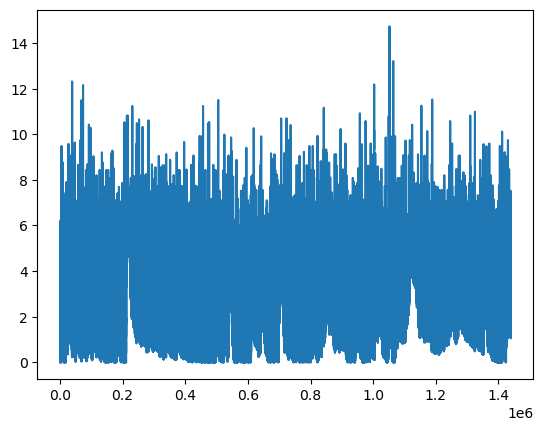

In [14]:
plt.plot(global_max_list)

In [58]:
max_data_full = np.array(global_max_list)
max_data = max_data_full[np.where(max_data_full>4.6**2/2)]

Text(0, 0.5, 'Sigma significance')

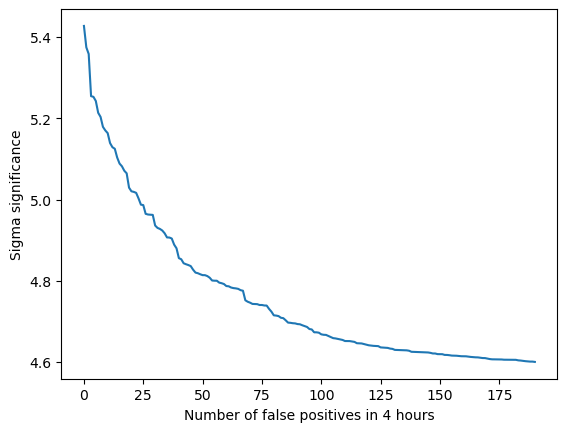

In [42]:
plt.plot(np.flip(np.sqrt(2*max_data)))
plt.xlabel("Number of false positives in 4 hours")
plt.ylabel("Sigma significance")

In [59]:
threshold = 3**2/2

over_t = np.where(max_data_full>threshold)[0]
under_t = np.where(max_data_full<threshold)[0]+1
anomalies = np.intersect1d(over_t, under_t)

In [61]:
len(anomalies)

8503